#### Imports and helper functions

In [1]:
#! /usr/bin/env python3

%load_ext autoreload
# %autoreload 0
%autoreload

import copy
from itertools import product
import warnings
import pandas as pd
import numpy as np

import matplotlib
from matplotlib import pyplot as plt, ticker
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
from matplotlib.patches import FancyArrow
from matplotlib.legend_handler import HandlerPatch

import scienceplots # for ieee style
import seaborn as sns

from pyaarapsi.vpr.vpr_helpers import VPRDescriptor
from pyaarapsi.pathing.basic import calc_path_stats
from pyaarapsi.core.transforms import apply_homogeneous_transform, TransformBuilder

from pyaarapsi.nn.enums import ApplyModel
from pyaarapsi.nn.vpr_helpers import make_load_vpr_dataset
from pyaarapsi.nn.visualize import make_legend_arrow
from pyaarapsi.nn.visualize import adj_make_split_axes_y_linlog, mean_confidence_interval
from pyaarapsi.nn.params import DFExperiment1, Experiment1, DFExperiment2, Experiment2, DFGeneral, \
    General, DFNNTrain, DFNNTest, NNGeneral

from experiment_functions import make_load_experiment_2

plt.style.use('ieee')

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

%matplotlib inline

EXPERIMENT1     = Experiment1()
DF_EXPERIMENT1  = DFExperiment1()
EXPERIMENT2     = Experiment2()
DF_EXPERIMENT2  = DFExperiment2()
DF_GENERAL      = DFGeneral()
GENERAL         = General()
DF_NN_TRAIN     = DFNNTrain()
DF_NN_TEST      = DFNNTest()
NN_GENERAL      = NNGeneral()

/home/owen/miniforge3/envs/ros1env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Error code: 
Exception Caught.
	Details: <class 'ModuleNotFoundError'> No module named 'aarapsi_robot_pack'
	File /home/owen/miniforge3/envs/ros1env/lib/python3.11/site-packages/pyaarapsi/core/ros_tools.py [Line 28]
	Trace: <module> [28] >> <module> [5]


# All feature types

## Data

In [2]:
%matplotlib inline
_df_features_fusion = {}
_df_features_office = {}
_df_features_campus = {}

DF_NN_TRAIN_FUSION = DFNNTrain()
DF_NN_TRAIN_FUSION.APPLY_MODEL = ApplyModel.USE_FUSED
DF_NN_TRAIN_OFFICE = DFNNTrain()
DF_NN_TRAIN_OFFICE.APPLY_MODEL = ApplyModel.USE_OFFICE
DF_NN_TRAIN_CAMPUS = DFNNTrain()
DF_NN_TRAIN_CAMPUS.APPLY_MODEL = ApplyModel.USE_CAMPUS

GENERAL.VPR_DP.printer = None if GENERAL.VPRDP_VERBOSE else lambda *args, **kwargs: None
GENERAL.VPR_DP.use_tqdm = GENERAL.VPRDP_VERBOSE

print("************************\nFUSION\n************************")
for DESCRIPTOR_TYPE in DF_GENERAL.DESCRIPTOR_TYPES:
    data_fusion = make_load_experiment_2(  
        vpr_descriptor=DESCRIPTOR_TYPE, df_nn_train=DF_NN_TRAIN_FUSION,
        df_nn_test=DF_NN_TEST, nn_general=NN_GENERAL,
        df_exp1=DF_EXPERIMENT1, exp1=EXPERIMENT1, 
        df_exp2=DF_EXPERIMENT2, exp2=EXPERIMENT2,
        df_general=DF_GENERAL, general=GENERAL)

    data_fusion['vprfeaturetype'] = DESCRIPTOR_TYPE.name
    data_fusion['vprfeaturename'] = DESCRIPTOR_TYPE.get_descriptor_name()
    data_fusion['svmfactor1type'] = DF_NN_TRAIN_FUSION.VPR.SVM_FACTORS[DESCRIPTOR_TYPE.name][0]
    data_fusion['svmfactor2type'] = DF_NN_TRAIN_FUSION.VPR.SVM_FACTORS[DESCRIPTOR_TYPE.name][1]

    _df_features_fusion[DESCRIPTOR_TYPE.name] = copy.deepcopy(data_fusion)
    del data_fusion
df_features_fusion = pd.concat([_df_features_fusion[i] for i in _df_features_fusion.keys()])

print("************************\nOFFICE\n************************")
for DESCRIPTOR_TYPE in DF_GENERAL.DESCRIPTOR_TYPES:
    data_office = make_load_experiment_2(
        vpr_descriptor=DESCRIPTOR_TYPE, df_nn_train=DF_NN_TRAIN_OFFICE,
        df_nn_test=DF_NN_TEST, nn_general=NN_GENERAL,
        df_exp1=DF_EXPERIMENT1, exp1=EXPERIMENT1, 
        df_exp2=DF_EXPERIMENT2, exp2=EXPERIMENT2,
        df_general=DF_GENERAL, general=GENERAL)

    data_office['vprfeaturetype'] = DESCRIPTOR_TYPE.name
    data_office['vprfeaturename'] = DESCRIPTOR_TYPE.get_descriptor_name()
    data_office['svmfactor1type'] = DF_NN_TRAIN_OFFICE.VPR.SVM_FACTORS[DESCRIPTOR_TYPE.name][0]
    data_office['svmfactor2type'] = DF_NN_TRAIN_OFFICE.VPR.SVM_FACTORS[DESCRIPTOR_TYPE.name][1]

    _df_features_office[DESCRIPTOR_TYPE.name] = copy.deepcopy(data_office)
    del data_office
df_features_office = pd.concat([_df_features_office[i] for i in _df_features_office.keys()])

print("************************\nCAMPUS\n************************")
for DESCRIPTOR_TYPE in DF_GENERAL.DESCRIPTOR_TYPES:
    data_campus = make_load_experiment_2(
        vpr_descriptor=DESCRIPTOR_TYPE, df_nn_train=DF_NN_TRAIN_CAMPUS,
        df_nn_test=DF_NN_TEST, nn_general=NN_GENERAL,
        df_exp1=DF_EXPERIMENT1, exp1=EXPERIMENT1, 
        df_exp2=DF_EXPERIMENT2, exp2=EXPERIMENT2,
        df_general=DF_GENERAL, general=GENERAL)

    data_campus['vprfeaturetype'] = DESCRIPTOR_TYPE.name
    data_campus['vprfeaturename'] = DESCRIPTOR_TYPE.get_descriptor_name()
    data_campus['svmfactor1type'] = DF_NN_TRAIN_CAMPUS.VPR.SVM_FACTORS[DESCRIPTOR_TYPE.name][0]
    data_campus['svmfactor2type'] = DF_NN_TRAIN_CAMPUS.VPR.SVM_FACTORS[DESCRIPTOR_TYPE.name][1]

    _df_features_campus[DESCRIPTOR_TYPE.name] = copy.deepcopy(data_campus)
    del data_campus
df_features_campus = pd.concat([_df_features_campus[i] for i in _df_features_campus.keys()])

del DESCRIPTOR_TYPE

************************
FUSION
************************
Data loaded (exp2_data_20250324).
Data loaded (exp2_data_20250324_0).
Data loaded (exp2_data_20250324_1).
************************
OFFICE
************************
Data loaded (exp2_data_20250324_2).
Data loaded (exp2_data_20250324_3).
Data loaded (exp2_data_20250324_4).
************************
CAMPUS
************************
Data loaded (exp2_data_20250324_5).
Data loaded (exp2_data_20250324_6).
Data loaded (exp2_data_20250324_7).


## Plots

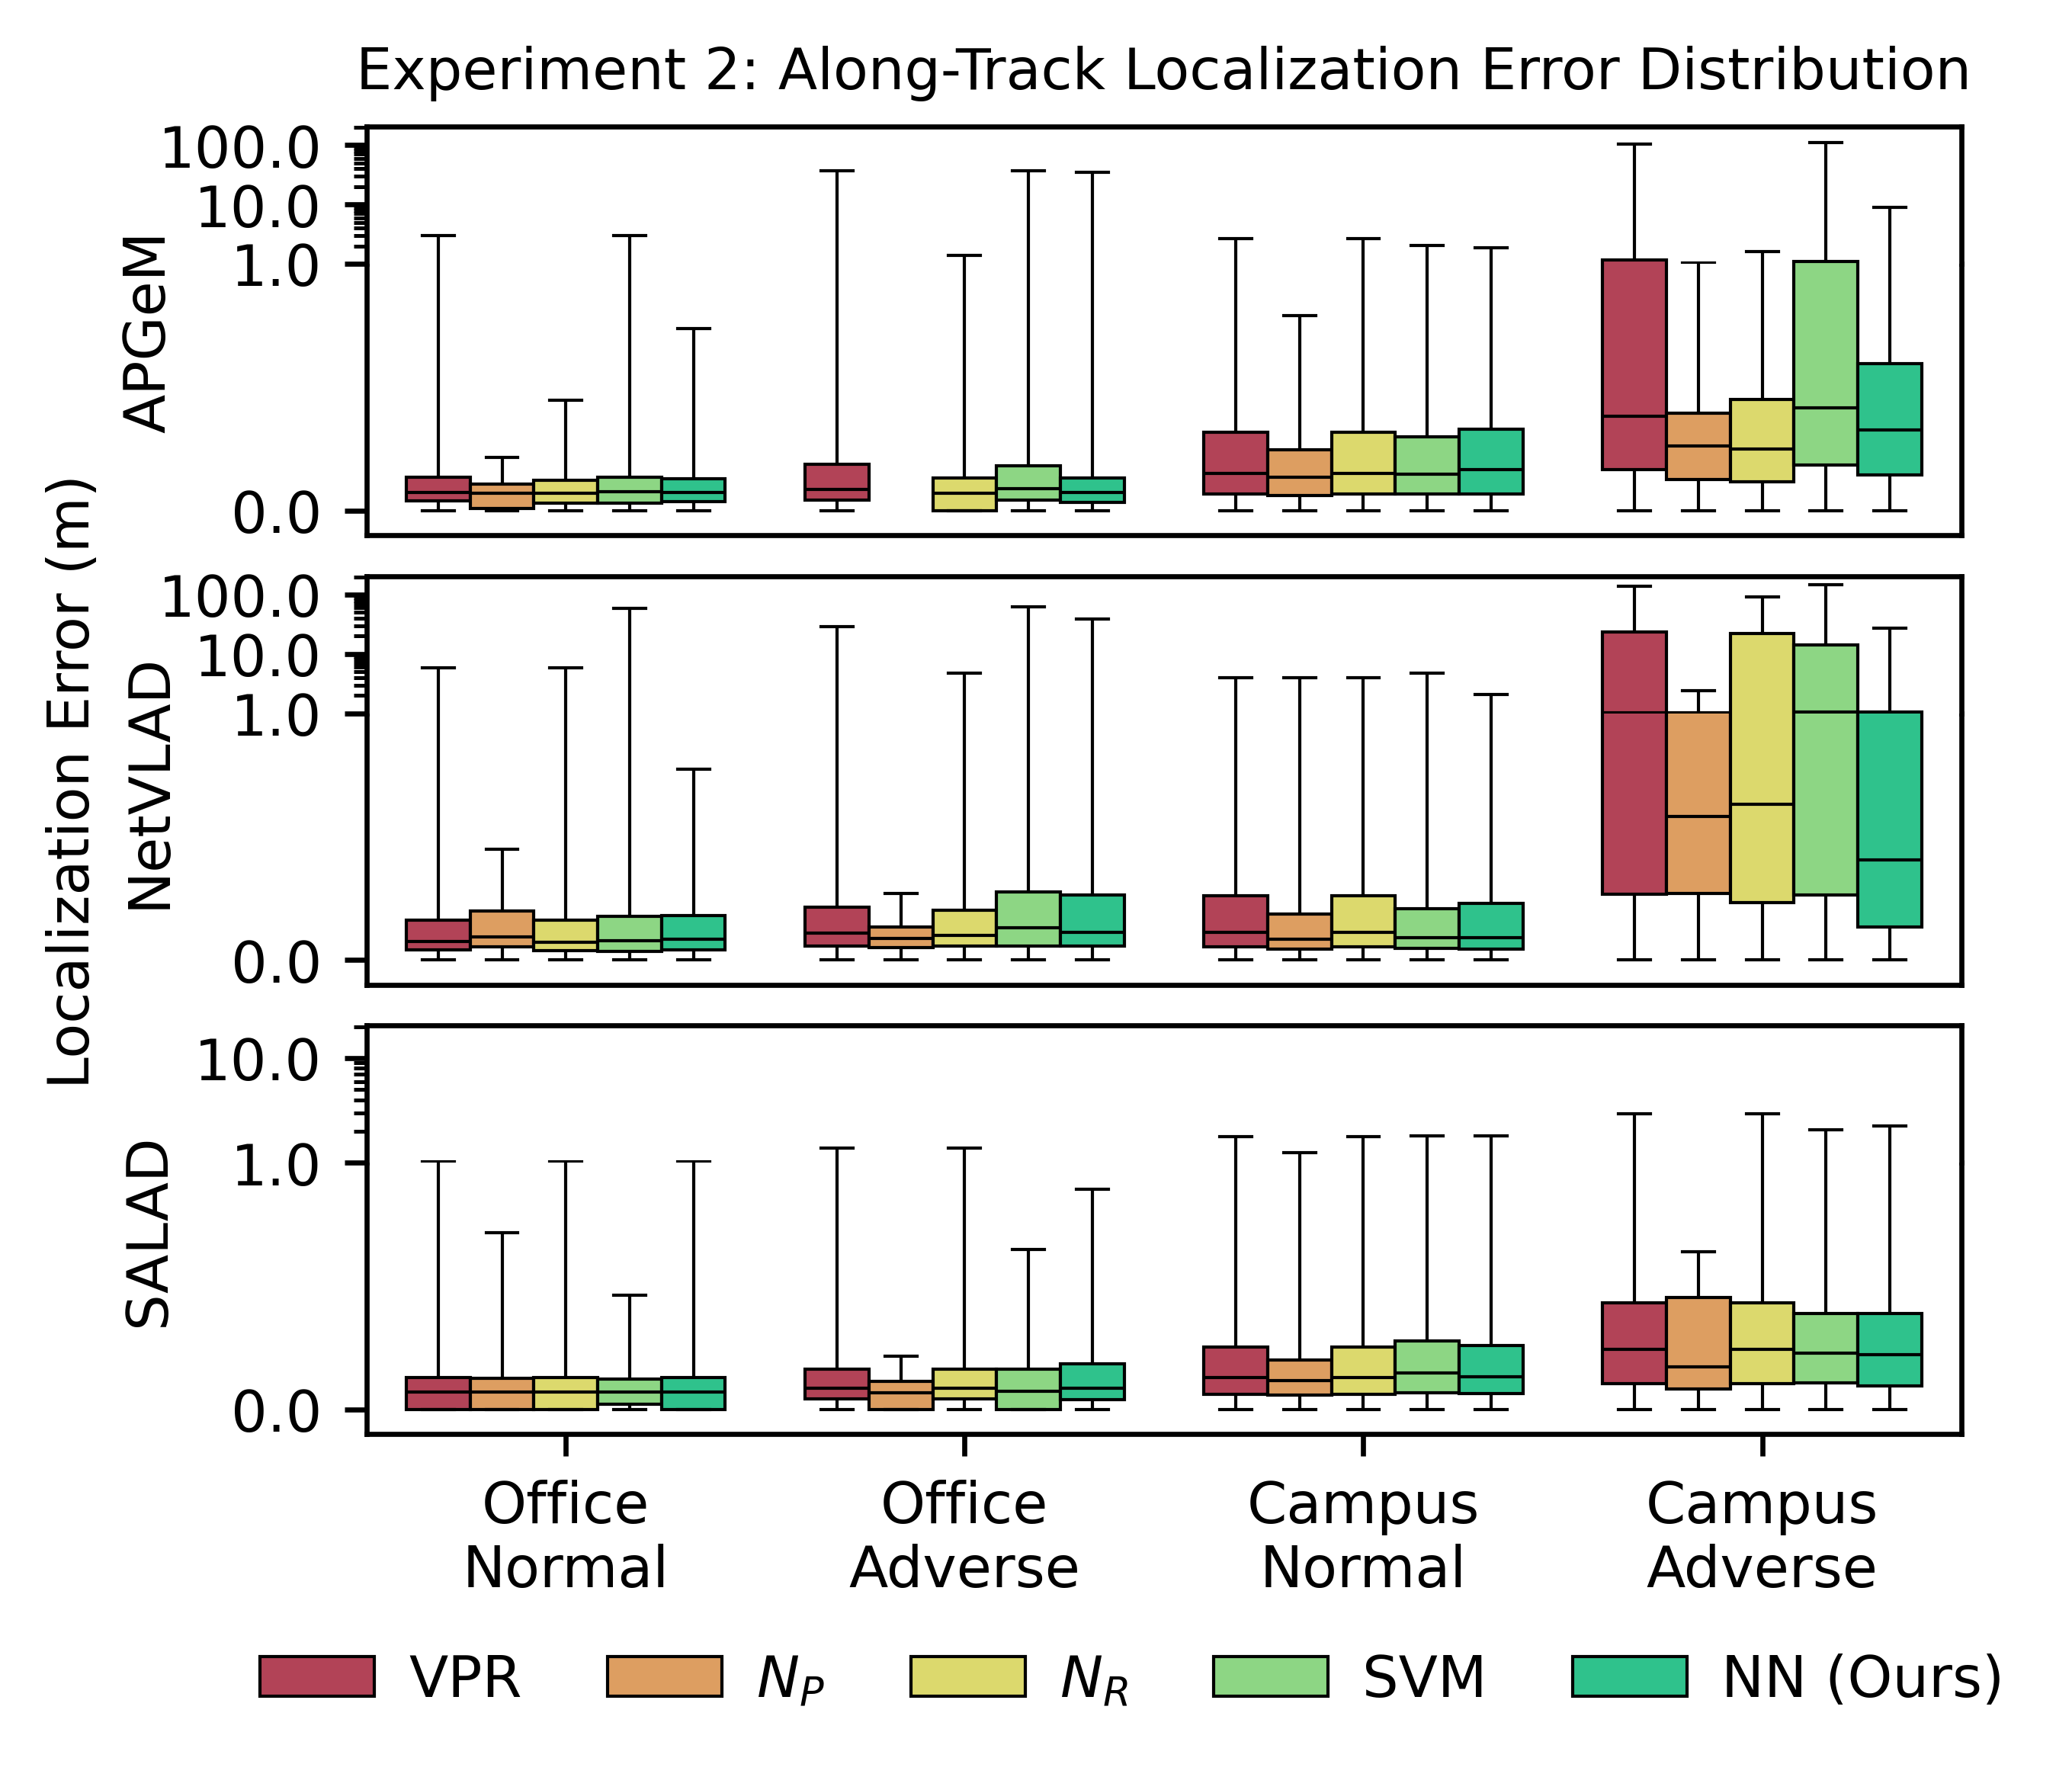

In [3]:
if True:
    # For some reason, this plot breaks in Seaborn v0.13.0
    # pip install seaborn==0.12.2; pgrep python | xargs kill -9
    # then rerun script.

    _s = 4.5/4.0

    fig_m1, axes_m1         = plt.subplots(3,1,figsize=(4*_s,_s*1.1*3), sharex=True)

    axes_m1_plotter         = lambda ft_type, ax: sns.boxplot(
        data=df_features_fusion[(df_features_fusion['vprfeaturetype']==ft_type)], 
        y='pos_error',x='set',hue='MODE',ax=ax, palette=General.PALETTE, whis=1000,
        hue_order=General.HUE_ORDER, order=General.SET_ORDER, linewidth=0.5, width=0.8, 
        flierprops=dict(alpha=.05, marker='.', markersize=4, markeredgecolor='none', markerfacecolor='k'),
        capprops=dict(color='k'),
        boxprops=dict(edgecolor='k'), whiskerprops=dict(color='k'), medianprops=dict(color='k'))
    
    axes_m1log0 = adj_make_split_axes_y_linlog(axes_m1[0], [-0.1, 1, 205], 
                    lambda ax: axes_m1_plotter('APGEM', ax), size=0.3, swap_order=False)
    axes_m1log1 = adj_make_split_axes_y_linlog(axes_m1[1], [-0.1, 1, 205], 
                    lambda ax: axes_m1_plotter('NETVLAD', ax), size=0.3, swap_order=False)
    axes_m1log2 = adj_make_split_axes_y_linlog(axes_m1[2], [-0.1, 1, 20.5], 
                    lambda ax: axes_m1_plotter('SALAD', ax), size=0.3, swap_order=False)

    _formatter = ticker.FormatStrFormatter("%0.1f")
    axes_m1[0].yaxis.set_major_formatter(_formatter)
    axes_m1[1].yaxis.set_major_formatter(_formatter)
    axes_m1[2].yaxis.set_major_formatter(_formatter)
    axes_m1log0.yaxis.set_major_formatter(_formatter)
    axes_m1log1.yaxis.set_major_formatter(_formatter)
    axes_m1log2.yaxis.set_major_formatter(_formatter)

    axes_m1[0].tick_params(bottom=False)
    axes_m1[1].tick_params(bottom=False)

    small_frame0 = fig_m1.add_subplot(311, frameon=False)
    small_frame1 = fig_m1.add_subplot(312, frameon=False)
    small_frame2 = fig_m1.add_subplot(313, frameon=False)

    small_frame0.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    small_frame1.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    small_frame2.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

    small_frame0.set_ylabel('APGeM',      fontsize=9, labelpad=5)
    small_frame1.set_ylabel('NetVLAD',  fontsize=9, labelpad=5)
    small_frame2.set_ylabel('SALAD',    fontsize=9, labelpad=5)

    big_frame = fig_m1.add_subplot(111, frameon=False)
    big_frame.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_frame.set_ylabel('Localization Error (m)',  labelpad=22, fontsize=9)
    big_frame.set_title('Experiment 2: Along-Track Localization Error Distribution', fontsize=9)

    lgnd = axes_m1[2].legend(loc='lower center', frameon=False, ncol=5, bbox_to_anchor=(0.48,-1.2),
                             fontsize=9, labelspacing=0, columnspacing=1.5, handletextpad=0.6)

    axes_m1[0].tick_params(axis='both', which='both', labelsize=9)
    axes_m1[1].tick_params(axis='both', which='both', labelsize=9)
    axes_m1[2].tick_params(axis='both', which='both', labelsize=9)
    axes_m1log0.tick_params(axis='both', which='both', labelsize=9)
    axes_m1log1.tick_params(axis='both', which='both', labelsize=9)
    axes_m1log2.tick_params(axis='both', which='both', labelsize=9)

    fig_m1.subplots_adjust(hspace=0.1)

    fig_m1.canvas.draw()

    path = GENERAL.DIR_MEDIA + '/exp2_new_extended_key_results_vertical' #relative to file directory
    fig_m1.savefig(path+'.pdf', format='pdf', bbox_extra_artists=(lgnd,), dpi=300, pad_inches=0, bbox_inches='tight')
    fig_m1.savefig(path+'.png', format='png', bbox_extra_artists=(lgnd,), dpi=300, pad_inches=0, bbox_inches='tight')

## Tables

In [4]:
if True:
    LATEX_MODE = True
    ONLY_AGGREGATES = True
    TWO_TABLES = True
    UNDERLINE_MODE = False # latex only

    offset = '        '
    if LATEX_MODE:
        _la  = '% 13s'
        _sb  = r'\B{'
        _si  = r'\I{'
        _su  = r'\U{'
        _sn  = r'   '
        _eb  = r'm  }'
        _ei  = r'm  }'
        _en  = r'm   '
        _ebp = r'\% }'
        _eip = r'\% }'
        _enp = r'\%  '
        _ee  = r' \\'
        _sf  = '& % 14s '
        if UNDERLINE_MODE:
            _si = _su
    else:
        _la  = '% 11s'
        _sb  = r''
        _si  = r''
        _sn  = r''
        _eb  = r'm* '
        _ei  = r'm^ '
        _en  = r'm  '
        _ebp = r'%%*'
        _eip = r'%%^'
        _enp = r'%% '
        _ee  = r'   '
        _sf  = '| % 8s '
    print()
    long_featname = np.max([len(i.name) for i in DF_GENERAL.DESCRIPTOR_TYPES])
    df_ = df_features_fusion[(df_features_fusion['slice_length']*10).astype(int).isin([15])]

    def make_xfix(_b, _i, _n, c, bests, best_inds, skip_inds):
        '''
        _b -> prefix if bold
        _i -> prefix if italics
        _n -> prefix if normal
        c  -> index of best_inds in question
        '''
        italics_inds = []
        italics_values = []
        bold_inds = []
        bold_values = []
        bold_first = -1
        for p, i in enumerate(best_inds):
            if (i not in skip_inds):
                if (not bold_inds) or (bests[i] in bold_values):
                    bold_inds.append(i)
                    bold_values.append(bests[i])
                    if bold_first == -1:
                        bold_first = p
        for p, i in enumerate(best_inds):
            if (i in skip_inds):
                # if an italics_ind value beats the best bold_value
                if ((not italics_inds) and ((p < bold_first) or (bests[i] in bold_values))) \
                    or (bests[i] in italics_values):
                    italics_inds.append(i)
                    italics_values.append(bests[i])
        return _b if c in bold_inds else (_i if c in italics_inds else (_n))

    def table_start():
        print(r'    \centering')
        print(r'    \scriptsize')
        print(r'    \setlength\tabcolsep{1.2mm}')
        print(r'    \begin{tabular}{lcL{11mm}|M{9mm}|M{9mm}M{9mm}|M{9mm}M{9mm}|}')

    def table_end(table_label: str):
        print(r'    \end{tabular}')
        print(r'    \label{table:' + table_label + r'}')
        print(r'    \vspace*{-\baselineskip}')

    def make_main_table(show_a_t_stats: bool, show_perc_stats: bool):
        thresh_inds = [GENERAL.PRED_TYPES.index('nvp'), GENERAL.PRED_TYPES.index('nvr')]
        num_rows = (3 if show_a_t_stats else 0) + (2 if show_perc_stats else 0)
        for feat in DF_GENERAL.DESCRIPTOR_TYPES:
            if LATEX_MODE:
                if feat != DF_GENERAL.DESCRIPTOR_TYPES[0]:
                    if not ONLY_AGGREGATES:
                        print(offset + r'\hline')
                else:
                    if not ONLY_AGGREGATES:
                        print(offset + r'\cline{3-7}')
                    else:
                        print(offset + r'\cline{4-8}')
                if not ONLY_AGGREGATES:
                    print(offset + r'& & \multicolumn{5}{c|}{\B{' + feat.get_descriptor_name() \
                          + r' Features}} \\')
                if feat == DF_GENERAL.DESCRIPTOR_TYPES[0]:
                    sep = r' & ' if not ONLY_AGGREGATES else r' & & '
                    print(offset + r'&' + sep 
                        + r'\B{Baseline} & \multicolumn{4}{c|}{\B{Filtering Technique}} \\')
                    print(offset + r'&' + sep 
                        + r'\B{VPR}      & \boldmath{$N_P$} & '
                          r'\boldmath{$N_R$} & \B{SVM} & \B{Ours} \\')
                print(offset + r'\hline')
            else:
                print('\n' + feat.get_descriptor_name())
            for env, cond in product(['Office', 'Campus', 'Aggregate'], ['Normal', 'Adverse']):
                if (env == 'Aggregate'): 
                    if (cond == 'Adverse'): break
                    else: set_name = env
                else:
                    if ONLY_AGGREGATES: continue
                    set_name = env + '\n' + cond
                
                if not (set_name == 'Aggregate'):
                    df__ = df_[(df_['set'] == set_name) & (df_['vprfeaturetype']==feat.name)]
                else:
                    df__ = df_[(df_['vprfeaturetype']==feat.name)]

                stats = {}
                for label in GENERAL.PRED_TYPES:
                    stats[label] = {k: np.nan 
                                    for k in ['mean', 'conf', 'med', 'max', 'prec', 'rcll']}
                    data = df__[df__['mode']==label]
                    if (data['pos_error'] != np.nan).sum() > 0:
                        stats[label]['mean'], stats[label]['conf'] = mean_confidence_interval(
                            data['pos_error'].to_numpy(dtype=float))
                        stats[label]['med'] = np.nanmedian(data['pos_error'].to_numpy(dtype=float))
                        stats[label]['max'] = np.nanmax(data['pos_error'].to_numpy(dtype=float))
                        stats[label]['prec'] = 100 * (data['TP'].sum() \
                                                / (data['TP'].sum() + data['FP'].sum()))
                        stats[label]['rcll'] = 100 * (data['TP'].sum() \
                                                / (data['TP'].sum() + data['FN'].sum()))

                num_labels = len(stats.keys())
                means = np.round(np.array([stats[label]['mean'] for label in stats.keys()]),2)
                means_best = np.argsort(means)
                means_str = ''.join([_sf % (make_xfix(_sb, _si, _sn, i, means, means_best, thresh_inds) 
                                    + ('%6.2f' % means[i])
                                    + make_xfix(_eb, _ei, _en, i, means, means_best, thresh_inds))
                                            for i in range(num_labels)])

                medis = np.round(np.array([stats[label]['med'] for label in stats.keys()]),2)
                medis_best = np.argsort(medis)
                medis_str = ''.join([_sf % (make_xfix(_sb, _si, _sn, i, medis, medis_best, thresh_inds) 
                                    + ('%6.2f' % medis[i])
                                    + make_xfix(_eb, _ei, _en, i, medis, medis_best, thresh_inds))
                                            for i in range(num_labels)])

                max_s = np.round(np.array([stats[label]['max'] for label in stats.keys()]),2)
                max_s_best = np.argsort(max_s)
                max_s_str = ''.join([_sf % (make_xfix(_sb, _si, _sn, i, max_s, max_s_best, thresh_inds) 
                                    + ('%6.2f' % max_s[i])
                                    + make_xfix(_eb, _ei, _en, i, max_s, max_s_best, thresh_inds))
                                            for i in range(num_labels)])
                
                precs = np.round(np.array([stats[label]['prec'] for label in stats.keys()]),2)
                precs_best = np.argsort(precs)[::-1]
                precs_str = ''.join([_sf % (make_xfix(_sb, _si, _sn, i, precs, precs_best, thresh_inds) 
                                    + ('%6.2f' % precs[i])
                                    + make_xfix(_ebp, _eip, _enp, i, precs, precs_best, thresh_inds))
                                            for i in range(num_labels)])
                
                rclls = np.round(np.array([stats[label]['rcll'] for label in stats.keys()]),2)
                rclls_best = np.argsort(rclls)[::-1]
                rclls_str = ''.join([_sf % (make_xfix(_sb, _si, _sn, i, rclls, rclls_best, thresh_inds) 
                                    + ('%6.2f' % rclls[i])
                                    + make_xfix(_ebp, _eip, _enp, i, rclls, rclls_best, thresh_inds))
                                            for i in range(num_labels)])

                _set_name = set_name.replace('\n',' ')
                if not LATEX_MODE:
                    print(_set_name)
                    print((' '*7) + ''.join([_la % i 
                                                for i in ['VPR', 'NVP', 'NVR', 'SVM', 'NN']]))
                if LATEX_MODE:
                    if not ONLY_AGGREGATES:
                        _first_whole = r'\ocMCSMR{1}{|c|}{' + str(num_rows)  \
                                + r'}{' + _set_name + r'}' \
                                + (' '*5 if env == 'Aggregate' else \
                                        (' ' if cond == 'Normal' else ''))
                        _other = r'\ocblb'
                        _other_whole = _other + (' ' * (len(_first_whole) - len(_other)))
                    else:
                        featname_diff = long_featname - len(feat.get_descriptor_name())
                        _first_whole = r'\ocMCSMRT{2}{|c|}{' + str(num_rows)  \
                                + r'}{' + feat.get_descriptor_name() + r' Aggregate}' \
                            + (' ' * featname_diff)
                        _other = r'\ocblbT'
                        _other_whole = _other + (' ' * (len(_first_whole) - len(_other)))
                    if show_a_t_stats:
                        print(offset + _first_whole + ' &      Mean ' + means_str + _ee)
                        print(offset + _other_whole + ' &    Median ' + medis_str + _ee)
                        print(offset + _other_whole + ' &   Maximum ' + max_s_str + _ee)
                    if show_perc_stats:
                        if show_a_t_stats:
                            print(offset + _other_whole + ' & Precision ' + precs_str + _ee)
                        else:
                            print(offset + _first_whole + ' & Precision ' + precs_str + _ee)
                        print(offset + _other_whole + ' &    Recall ' + rclls_str + _ee)
                    if env != 'Aggregate':
                        print(offset + '\hline')
                else:
                    if show_a_t_stats:
                        print('     Mean: ' + means_str)
                        print('   Median: ' + medis_str)
                        print('  Maximum: ' + max_s_str)
                    if show_perc_stats:
                        print('Precision: ' + precs_str)
                        print('   Recall: ' + rclls_str)
        if LATEX_MODE:
            print(offset + '\hline')
    
    if not TWO_TABLES:
        if LATEX_MODE:
            print(r'\begin{table}[!ht]')
            print(r'    \caption{Experiment 2 along-track localization error in meters, as well as '
                r'system precision and recall. Best '
                  r'performance for each feature type is indicated by bold, ignoring naive '
                  r'thresholds. Naive thresholds are italicized if best performance.}')
            table_start()
        make_main_table(True, True)
        if LATEX_MODE:
            table_end("exp2table_new")
            print(r'\end{table}')
    else:
        if LATEX_MODE:
            print(r'\begin{table}[!ht]')
            print(r'    \caption{Experiment 2 along-track localization error in meters. Best '
                  r'performance for each feature type is indicated by bold, ignoring naive '
                  r'thresholds. Naive thresholds are italicized if best performance.}')
            table_start()
        make_main_table(True, False)
        if LATEX_MODE:
            table_end("exp2table_new")
            print(r'\end{table}')
        print()
        if LATEX_MODE:
            print(r'\begin{table}[!ht]')
            print(r'    \caption{Experiment 2 system precision and recall. Best '
                  r'performance for each feature type is indicated by bold, ignoring naive '
                  r'thresholds. Naive thresholds are italicized if best performance.}')
            table_start()
        make_main_table(False, True)
        if LATEX_MODE:
            table_end("exp2table2_new")
            print(r'\end{table}')


\begin{table}[!ht]
    \caption{Experiment 2 along-track localization error in meters. Best performance for each feature type is indicated by bold, ignoring naive thresholds. Naive thresholds are italicized if best performance.}
    \centering
    \scriptsize
    \setlength\tabcolsep{1.2mm}
    \begin{tabular}{lcL{11mm}|M{9mm}|M{9mm}M{9mm}|M{9mm}M{9mm}|}
        \cline{4-8}
        & & & \B{Baseline} & \multicolumn{4}{c|}{\B{Filtering Technique}} \\
        & & & \B{VPR}      & \boldmath{$N_P$} & \boldmath{$N_R$} & \B{SVM} & \B{Ours} \\
        \hline
        \ocMCSMRT{2}{|c|}{3}{AP-GeM Aggregate}  &      Mean &       2.27m    &  \I{  0.18m  } &       0.19m    &       2.12m    &  \B{  0.45m  }  \\
        \ocblbT                                 &    Median &       0.13m    &       0.13m    &  \I{  0.11m  } &       0.13m    &  \B{  0.12m  }  \\
        \ocblbT                                 &   Maximum &     104.23m    &  \I{  1.04m  } &       2.65m    &     110.90m    &  \B{ 35.15m  

In [5]:
for feat in DF_GENERAL.DESCRIPTOR_TYPES:
    for env, cond in product(['Office', 'Campus', 'Aggregate'], ['Normal', 'Adverse']):
        if (env == 'Aggregate'): 
            if (cond == 'Adverse'): break
            else: set_name = env
        else:
            set_name = env + '\n' + cond
        
        if not (set_name == 'Aggregate'):
            df__ = df_[(df_['set'] == set_name) & (df_['vprfeaturetype']==feat.name)]
        else:
            df__ = df_[(df_['vprfeaturetype']==feat.name)]
        print(feat.name, [env], [cond], [set_name], df__.empty)
print(df_['set'].unique())
print(df_['vprfeaturetype'].unique())

APGEM ['Office'] ['Normal'] ['Office\nNormal'] False
APGEM ['Office'] ['Adverse'] ['Office\nAdverse'] False
APGEM ['Campus'] ['Normal'] ['Campus\nNormal'] False
APGEM ['Campus'] ['Adverse'] ['Campus\nAdverse'] False
APGEM ['Aggregate'] ['Normal'] ['Aggregate'] False
NETVLAD ['Office'] ['Normal'] ['Office\nNormal'] False
NETVLAD ['Office'] ['Adverse'] ['Office\nAdverse'] False
NETVLAD ['Campus'] ['Normal'] ['Campus\nNormal'] False
NETVLAD ['Campus'] ['Adverse'] ['Campus\nAdverse'] False
NETVLAD ['Aggregate'] ['Normal'] ['Aggregate'] False
SALAD ['Office'] ['Normal'] ['Office\nNormal'] False
SALAD ['Office'] ['Adverse'] ['Office\nAdverse'] False
SALAD ['Campus'] ['Normal'] ['Campus\nNormal'] False
SALAD ['Campus'] ['Adverse'] ['Campus\nAdverse'] False
SALAD ['Aggregate'] ['Normal'] ['Aggregate'] False
['Campus\nNormal' 'Campus\nAdverse' 'Office\nNormal' 'Office\nAdverse']
['APGEM' 'NETVLAD' 'SALAD']


## Extra Tables

In [6]:
if True:
    LATEX_MODE = False
    ONLY_AGGREGATES = False
    TWO_TABLES = True
    UNDERLINE_MODE = False # latex only

    offset = '        '
    if LATEX_MODE:
        _la  = '% 14s'
        _sb  = r'\B{'
        _si  = r'\I{'
        _su  = r'\U{'
        _sn  = r'   '
        _eb  = r'm  }'
        _ei  = r'm  }'
        _en  = r'm   '
        _ebp = r'\% }'
        _eip = r'\% }'
        _enp = r'\%  '
        _ee  = r' \\'
        _sf  = '& % 14s '
        if UNDERLINE_MODE:
            _si = _su
    else:
        _la  = '% 12s'
        _sb  = r''
        _si  = r''
        _sn  = r''
        _eb  = r'm* '
        _ei  = r'm^ '
        _en  = r'm  '
        _ebp = r'%%*'
        _eip = r'%%^'
        _enp = r'%% '
        _ee  = r'   '
        _sf  = '| % 8s '
    print()

    def make_xfix(_b, _i, _n, c, bests, best_inds, skip_inds):
        '''
        _b -> prefix if bold
        _i -> prefix if italics
        _n -> prefix if normal
        c  -> index of best_inds in question
        '''
        italics_inds = []
        italics_values = []
        bold_inds = []
        bold_values = []
        bold_first = -1
        for p, i in enumerate(best_inds):
            if (i not in skip_inds):
                if (not bold_inds) or (bests[i] in bold_values):
                    bold_inds.append(i)
                    bold_values.append(bests[i])
                    if bold_first == -1:
                        bold_first = p
        for p, i in enumerate(best_inds):
            if (i in skip_inds):
                # if an italics_ind value beats the best bold_value
                if ((not italics_inds) and ((p < bold_first) or (bests[i] in bold_values))) \
                    or (bests[i] in italics_values):
                    italics_inds.append(i)
                    italics_values.append(bests[i])
        return _b if c in bold_inds else (_i if c in italics_inds else (_n))

    def table_start():
        print(r'    \centering')
        print(r'    \scriptsize')
        print(r'    \setlength\tabcolsep{1.2mm}')
        print(r'    \begin{tabular}{lcL{11mm}|M{9mm}|M{9mm}M{9mm}|M{9mm}M{9mm}|}')

    def table_end(table_label: str):
        print(r'    \end{tabular}')
        print(r'    \label{table:' + table_label + r'}')
        print(r'    \vspace*{-\baselineskip}')

    if LATEX_MODE:
        print(r'\begin{table}[!ht]')
        print(r'    \caption{\textcolor{red}{TODO Best '
                r'performance for each feature type is indicated by bold, ignoring naive '
                r'thresholds. Naive thresholds are italicized if best performance.}}')
        table_start()

    thresh_inds = [GENERAL.PRED_TYPES.index('nvp'), GENERAL.PRED_TYPES.index('nvr')]

    for env in ['Office', 'Campus']:
        stats = {}
        for stat_label, label in [('vpr','vpr'), ('nnf','prd'), ('nno','prd'), ('nnc','prd')]:
            stats[stat_label] = {k: np.nan 
                            for k in ['mean', 'prec', 'rcll']}
            if stat_label in ['vpr', 'nnf']:
                df_  = df_features_fusion[(df_features_fusion['slice_length']*10).astype(int).isin([15])]
                if env == 'any':
                    data = df_[(df_['mode']==label)]
                else:
                    data = df_[(df_['environment'] == env) & (df_['mode']==label)]
            elif stat_label == 'nno':
                df_  = df_features_office[(df_features_office['slice_length']*10).astype(int).isin([15])]
                if env == 'any':
                    data = df_[(df_['mode']==label)]
                else:
                    data = df_[(df_['environment'] == env) & (df_['mode']==label)]
            elif stat_label == 'nnc':
                df_  = df_features_campus[(df_features_campus['slice_length']*10).astype(int).isin([15])]
                if env == 'any':
                    data = df_[(df_['mode']==label)]
                else:
                    data = df_[(df_['environment'] == env) & (df_['mode']==label)]
            else:
                raise Exception('bad stat_label: ' + stat_label)
            
            if (data['pos_error'] != np.nan).sum() > 0:
                stats[stat_label]['mean'] = mean_confidence_interval( \
                                        data['pos_error'].to_numpy(dtype=float))[0]
                stats[stat_label]['med'] = np.nanmedian(data['pos_error'].to_numpy(dtype=float))
                stats[stat_label]['max'] = np.nanmax(data['pos_error'].to_numpy(dtype=float))
                _precs = []
                _rclls = []
                for vpr_technique in data['vprfeaturetype'].unique().tolist():
                    _data = data[data['vprfeaturetype'] == vpr_technique]
                    _precs.append(100 * (_data['TP'].sum() \
                                            / (_data['TP'].sum() + _data['FP'].sum())))
                    _rclls.append(100 * (_data['TP'].sum() \
                                            / (_data['TP'].sum() + _data['FN'].sum())))
                stats[stat_label]['prec'] = np.mean(_precs)
                stats[stat_label]['rcll'] = np.mean(_rclls)
                
        num_labels = len(stats.keys())
        means = np.round(np.array([stats[label]['mean'] for label in stats.keys()]),2)
        means_best = np.argsort(means)
        means_str = ''.join([_sf % (make_xfix(_sb, _si, _sn, i, means, means_best, thresh_inds) 
                            + ('%6.2f' % means[i])
                            + make_xfix(_eb, _ei, _en, i, means, means_best, thresh_inds))
                                    for i in range(num_labels)])

        medis = np.round(np.array([stats[label]['med'] for label in stats.keys()]),2)
        medis_best = np.argsort(medis)
        medis_str = ''.join([_sf % (make_xfix(_sb, _si, _sn, i, medis, medis_best, thresh_inds) 
                            + ('%6.2f' % medis[i])
                            + make_xfix(_eb, _ei, _en, i, medis, medis_best, thresh_inds))
                                    for i in range(num_labels)])

        max_s = np.round(np.array([stats[label]['max'] for label in stats.keys()]),2)
        max_s_best = np.argsort(max_s)
        max_s_str = ''.join([_sf % (make_xfix(_sb, _si, _sn, i, max_s, max_s_best, thresh_inds) 
                            + ('%6.2f' % max_s[i])
                            + make_xfix(_eb, _ei, _en, i, max_s, max_s_best, thresh_inds))
                                    for i in range(num_labels)])
        
        precs = np.round(np.array([stats[label]['prec'] for label in stats.keys()]),2)
        precs_best = np.argsort(precs)[::-1]
        precs_str = ''.join([_sf % (make_xfix(_sb, _si, _sn, i, precs, precs_best, thresh_inds) 
                            + ('%6.2f' % precs[i])
                            + make_xfix(_ebp, _eip, _enp, i, precs, precs_best, thresh_inds))
                                    for i in range(num_labels)])
        
        rclls = np.round(np.array([stats[label]['rcll'] for label in stats.keys()]),2)
        rclls_best = np.argsort(rclls)[::-1]
        rclls_str = ''.join([_sf % (make_xfix(_sb, _si, _sn, i, rclls, rclls_best, thresh_inds) 
                            + ('%6.2f' % rclls[i])
                            + make_xfix(_ebp, _eip, _enp, i, rclls, rclls_best, thresh_inds))
                                    for i in range(num_labels)])
    
        if not LATEX_MODE:
            print(env)
            print((' '*11) + '|' + ''.join([_la % i 
                        for i in ['VPR    |', 'NN Fused |', 'NN Office |', 'NN Campus  ']]))
        if LATEX_MODE:
            _first_whole = r'\ocMCSMR{1}{|c|}{3}{' + env + r'}'
            _other = r'\ocblb'
            _other_whole = _other + (' ' * (len(_first_whole) - len(_other)))

            print(offset + _first_whole + ' &      Mean ' + means_str + _ee)
            print(offset + _first_whole + ' &    Median ' + medis_str + _ee)
            print(offset + _first_whole + ' &   Maximum ' + max_s_str + _ee)
            print(offset + _other_whole + ' & Precision ' + precs_str + _ee)
            print(offset + _other_whole + ' &    Recall ' + rclls_str + _ee)
        else:
            print('     Mean: ' + means_str)
            print('   Median: ' + medis_str)
            print('  Maximum: ' + max_s_str)
            print('Precision: ' + precs_str)
            print('   Recall: ' + rclls_str)
        if LATEX_MODE:
            print(offset + '\hline')
    
    if LATEX_MODE:
        table_end("agg_table")
        print(r'\end{table}')



Office
           |    VPR    |  NN Fused | NN Office | NN Campus  
     Mean: |   0.58m   |   0.37m   |   0.17m^  |   0.29m*  
   Median: |   0.08m*  |   0.08m^  |   0.08m^  |   0.08m*  
  Maximum: |  36.59m*  |  38.70m   |   4.17m^  |  39.06m   
Precision: |  99.34%%  |  99.88%%  |    nan%%^ |  99.97%%* 
   Recall: | 100.00%%* |  96.31%%  |  26.31%%  |  95.69%%  
Campus
           |    VPR    |  NN Fused | NN Office | NN Campus  
     Mean: |   3.09m   |   0.42m^  |   1.88m   |   0.60m*  
   Median: |   0.19m   |   0.16m   |   0.14m^  |   0.16m*  
  Maximum: | 137.64m*  |  27.58m^  |  59.88m   | 138.45m   
Precision: |  95.25%%  |  99.22%%  |    nan%%^ |  99.05%%* 
   Recall: | 100.00%%* |  88.87%%  |  34.51%%  |  89.35%%  


# Modes of Improvement Example Figure 

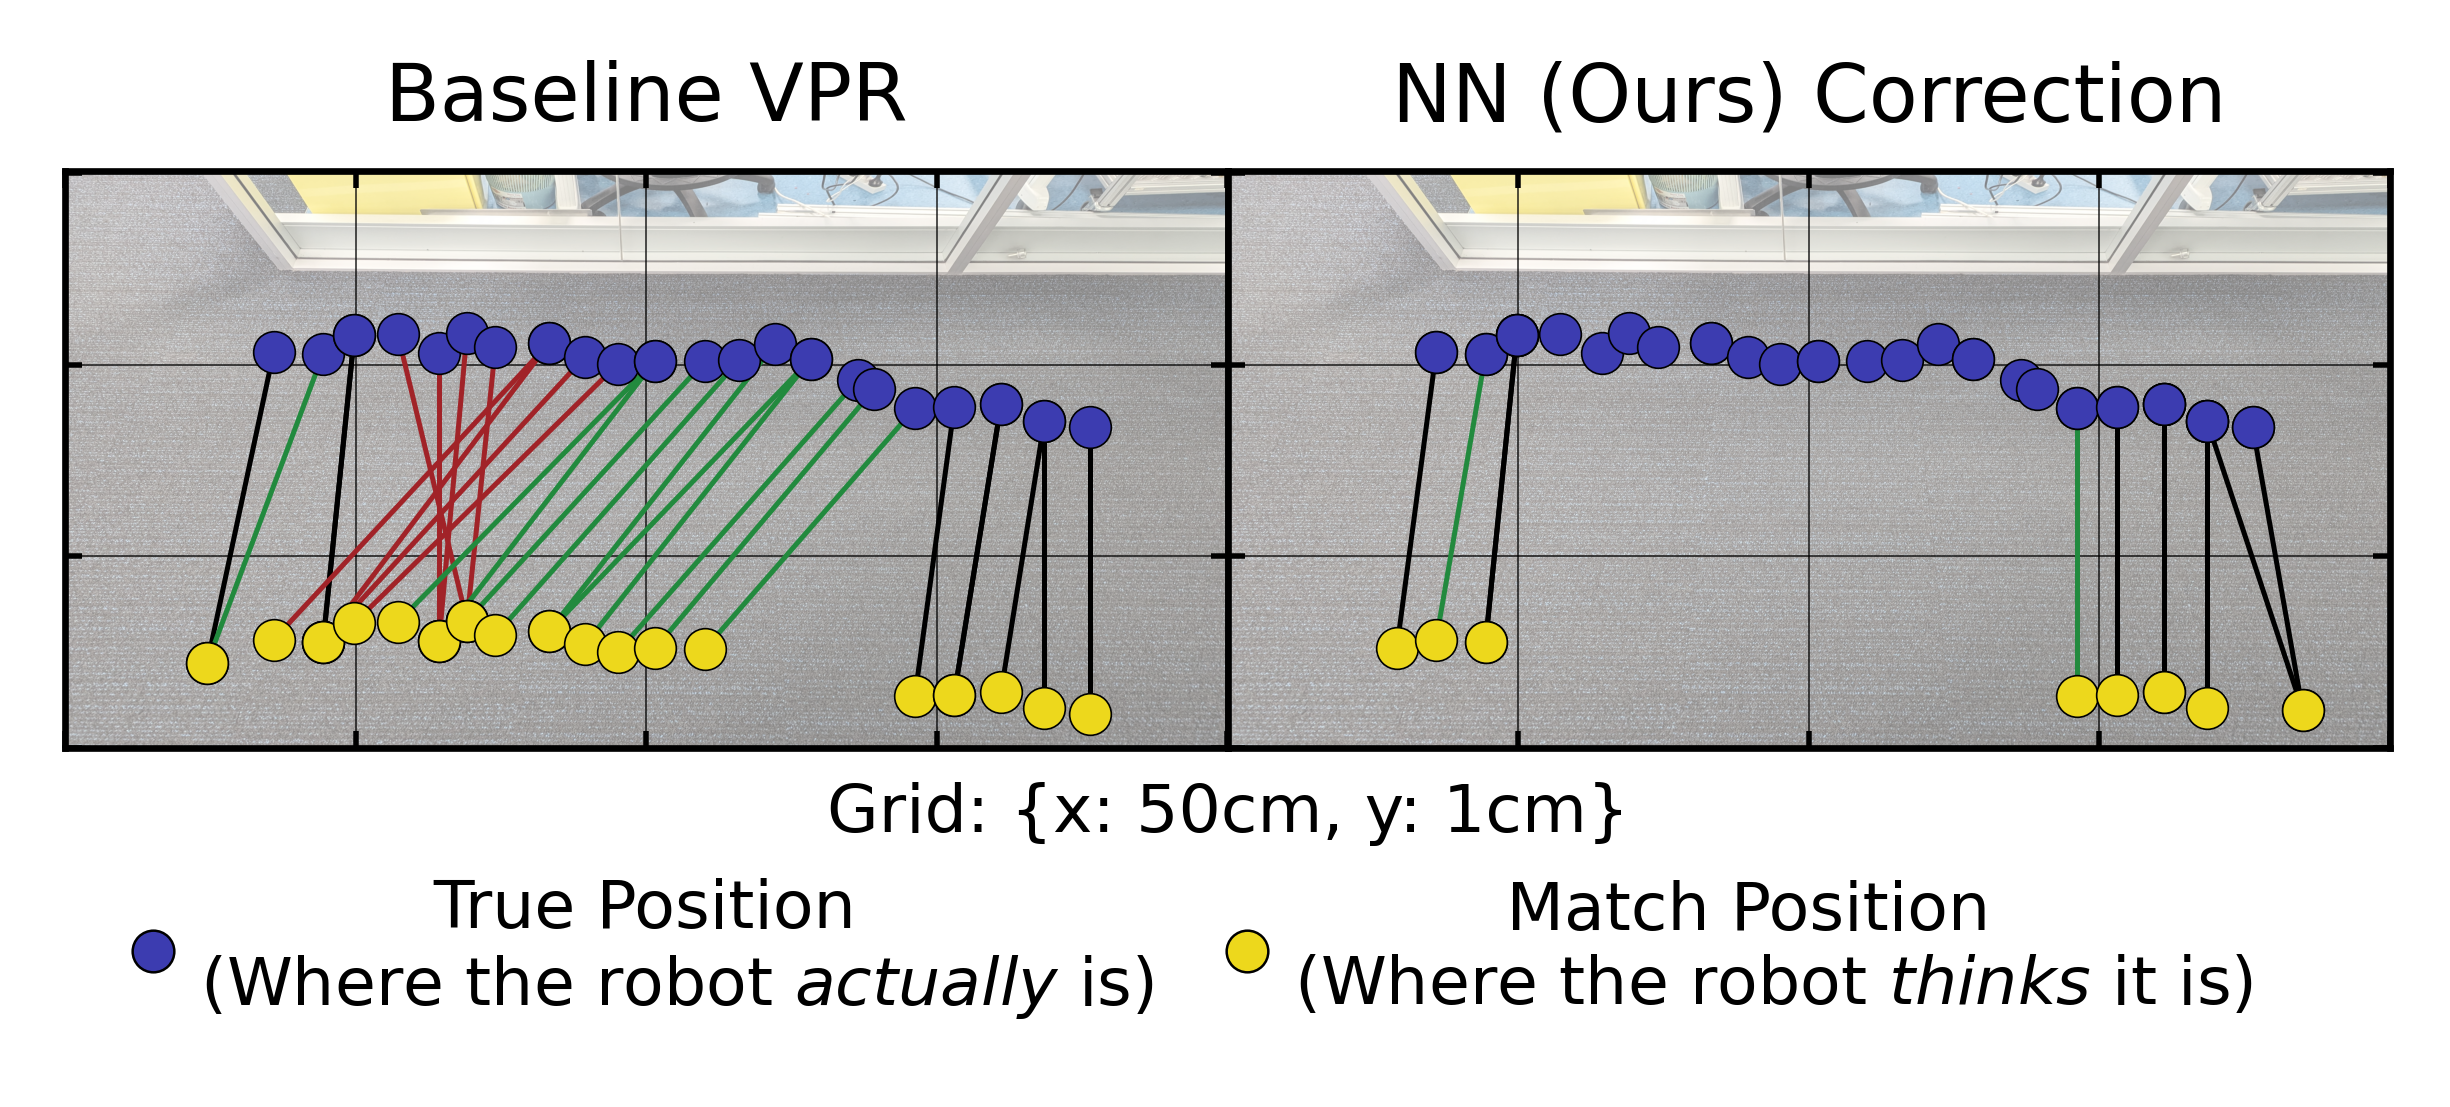

In [7]:
%matplotlib inline
vpr_descriptor = VPRDescriptor.APGEM
feature_name = "AP-GeM"
VERBOSE = False
if True:
    if True: # Dataset Loading
        df = df_features_fusion[(df_features_fusion['vprfeaturetype']==vpr_descriptor.name)]

        qry_subset = DF_GENERAL.TEST_QRY_SUBSETS[vpr_descriptor.name]
        ref_subset = DF_GENERAL.TEST_REF_SUBSETS[vpr_descriptor.name]

        dataset_params = {"combos": DF_GENERAL.VPR.COMBOS, "vpr_dp": GENERAL.VPR_DP,
                        "try_gen": True, "verbose": VERBOSE}

        ln_qry = make_load_vpr_dataset(env="Office", cond="Normal",  set_type="qry", subset=qry_subset, **dataset_params)
        cn_qry = make_load_vpr_dataset(env="Campus", cond="Normal",  set_type="qry", subset=qry_subset, **dataset_params)
        la_qry = make_load_vpr_dataset(env="Office", cond="Adverse", set_type="qry", subset=qry_subset, **dataset_params)
        ca_qry = make_load_vpr_dataset(env="Campus", cond="Adverse", set_type="qry", subset=qry_subset, **dataset_params)

        ln_ref = make_load_vpr_dataset(env="Office", cond="Normal",  set_type="ref", subset=ref_subset, **dataset_params)
        cn_ref = make_load_vpr_dataset(env="Campus", cond="Normal",  set_type="ref", subset=ref_subset, **dataset_params)
        la_ref = make_load_vpr_dataset(env="Office", cond="Adverse", set_type="ref", subset=ref_subset, **dataset_params)
        ca_ref = make_load_vpr_dataset(env="Campus", cond="Adverse", set_type="ref", subset=ref_subset, **dataset_params)

        _qry_hash = {'Office\nNormal': ln_qry, 'Office\nAdverse': la_qry, 'Campus\nNormal': cn_qry, 'Campus\nAdverse': ca_qry}
        _ref_hash = {'Office\nNormal': ln_ref, 'Office\nAdverse': la_ref, 'Campus\nNormal': cn_ref, 'Campus\nAdverse': ca_ref}

    if True: # Make main figure
        _env            = 'Office'
        _cond           = 'Adverse'
        _min            = 923
        _num            = 55
        _ang            = 0
        _all_offset     = [-11.4, -9.35]
        _true_offset    = [0.0, 0.15]
        _xlim           = [0, 2.001]
        _ylim           = [0, 0.301]
        _xstep          = 0.5
        _ystep          = 0.1
        _green_line     = "#228a3e"
        _red_line       = "#a12328"
        _true_marker    = "#3c3cb0"
        _match_marker   = "#edd81c"
        cols            = tuple(_green_line if i == 'g' else (_red_line if i == 'r' else i)
                                for i in "kgkkrrrrrrrrggggggggggkkkkkk")

        if True:
            if True:
                _set            = _env+'\n'+_cond
                _qry            = _qry_hash[_set]
                _ref            = _ref_hash[_set]
                _s = 5.0/4.0
                _shared_style   = dict(marker='.', linestyle='none', alpha=1.0, markersize=10, markeredgecolor='k', markeredgewidth=0.2)
                lines_style     = dict(linewidths=0.6)

                fig_5, axes_5   = plt.subplots(1,2,figsize=(4*_s,1*_s))

            if True: # plotting:
                vpr_data = df[(df['mode']=='vpr') & (df['set']==_set)]
                prd_data = df[(df['mode']=='prd') & (df['set']==_set)]

                _qry_wo    = _qry.pxyw_of(topic_name=DF_GENERAL.VPR.ENC_TOPIC)
                _ref_gt    = _ref.pxyw_of(topic_name=DF_GENERAL.VPR.ODOM_TOPIC)

                qry_wo_sum, qry_wo_len  = calc_path_stats(_qry_wo[:,0:2])
                ref_gt_sum              = calc_path_stats(_ref_gt)[0]
                dd_ind_min              = np.argmin(abs(np.array(qry_wo_sum) - 1.5)) + 1
                dd_ind_max              = len(_qry_wo)

                _max    = np.min([_min + _num, dd_ind_max-dd_ind_min])
                _step   = 2
                _slice  = slice(_min,_max, _step)
                dd      = slice(dd_ind_min, dd_ind_max+1)

                match_vpr   = np.array([_ref_gt[i,0:2].flatten().tolist() \
                                        for i in vpr_data['hist_match_index']])[_slice]
                match_prd   = np.array([_ref_gt[i,0:2].flatten().tolist() if not np.isnan(i) else [np.nan]*2
                                        for i in prd_data['hist_match_index']])[_slice]
                true_vpr    = np.array([_ref_gt[i,0:2].flatten().tolist()
                                        for i in vpr_data['hist_truth_index']])[_slice]
                true_prd    = np.array([_ref_gt[i,0:2].flatten().tolist() if not np.isnan(i) else [np.nan]*2
                                        for i in prd_data['hist_truth_index']])[_slice]
                assert len(true_vpr) == len(match_vpr)
                assert len(true_prd) == len(match_prd)
                tb = TransformBuilder()
                _H = tb.rotate(0,0,_ang,radians=False).translate(0.0,0,0).get()

                match_vpr = np.stack(apply_homogeneous_transform(_H, match_vpr[:,0], match_vpr[:,1])[0:2], axis=1) + _all_offset
                match_prd = np.stack(apply_homogeneous_transform(_H, match_prd[:,0], match_prd[:,1])[0:2], axis=1) + _all_offset
                true_vpr  = np.stack(apply_homogeneous_transform(_H, true_vpr[:,0], true_vpr[:,1])[0:2], axis=1) + _true_offset + _all_offset
                true_prd  = np.stack(apply_homogeneous_transform(_H, true_prd[:,0], true_prd[:,1])[0:2], axis=1) + _true_offset + _all_offset

                lines_vpr = [[(true_vpr[i,0], true_vpr[i,1]), (match_vpr[i,0], match_vpr[i,1])] for i in range(len(true_vpr))]
                lines_prd = [[(true_prd[i,0], true_prd[i,1]), (match_prd[i,0], match_prd[i,1])] for i in range(len(true_prd))]

                axes_5[0].add_collection(LineCollection(lines_vpr, **lines_style, colors=cols))
                axes_5[0].plot(true_vpr[:,0],   true_vpr[:,1],   markerfacecolor=_true_marker, **_shared_style)
                axes_5[0].plot(match_vpr[:,0],  match_vpr[:,1],  markerfacecolor=_match_marker, **_shared_style)
                axes_5[0].set_title("Baseline VPR")

                axes_5[1].add_collection(LineCollection(lines_prd, **lines_style, colors=cols))
                axes_5[1].plot(true_vpr[:,0],   true_vpr[:,1],   markerfacecolor=_true_marker, **_shared_style)
                axes_5[1].plot(true_prd[:,0],   true_prd[:,1],   markerfacecolor=_true_marker, **_shared_style, label='True Position')
                axes_5[1].plot(match_prd[:,0],  match_prd[:,1],  markerfacecolor=_match_marker, **_shared_style, label='Match Position')
                axes_5[1].set_title(GENERAL.MODE_NAMES["prd"] + " Correction")

            if True: # general:
                for ax in np.array(axes_5).flatten().tolist():
                    ax.tick_params(axis='both', which='both', direction='in', labelleft=False, 
                                                    labelbottom=False, right=True, top=True, length=2, width=0.66, 
                                                    grid_linewidth=0.2, grid_color='k', grid_alpha=0.8)
                    
                fig_5.subplots_adjust(hspace=0, wspace=0)

                axes_5i = fig_5.add_subplot(111, frameon=False)
                axes_5i.tick_params(axis='both', which='both', labelleft=False, labelbottom=False, left=False, bottom=False)
                axes_5i.set_xlabel(r'Grid: {x: 50cm, y: 1cm}', fontsize=8)

            if True: # legend
                legend_elements = [ 
                                    Line2D([0], [0], marker='.', label='           True Position \n(Where the robot $actually$ is)',  color='k',  linewidth=0, 
                                            markersize=10, markerfacecolor=_true_marker, markeredgewidth=0.3),
                                    Line2D([0], [0], marker='.', label='          Match Position \n(Where the robot $thinks$ it is)', color='k',  linewidth=0, 
                                            markersize=10, markerfacecolor=_match_marker, markeredgewidth=0.3),
                                ]
                lgnd = axes_5[0].legend(handles=legend_elements, loc='lower center', ncol=2, columnspacing=0.4, 
                                            handletextpad=-0.3, frameon=False, bbox_to_anchor=(0.95,-0.575), 
                                            handler_map={FancyArrow : HandlerPatch(patch_func=make_legend_arrow)})

            if True: # draw background images
                axes_5[0].imshow(GENERAL.BGIMG2[:,:], extent=[_xlim[0], _xlim[1], _ylim[0], _ylim[1]], alpha=0.5)
                axes_5[0].set_aspect('auto')
                axes_5[1].imshow(GENERAL.BGIMG2[:,:], extent=[_xlim[0], _xlim[1], _ylim[0], _ylim[1]], alpha=0.5)
                axes_5[1].set_aspect('auto')

            if True: # ticks, lims
                for ax in np.array(axes_5).flatten().tolist():
                    ax.set_xticks(np.arange(_xlim[0],_xlim[1],_xstep))
                    ax.set_yticks(np.arange(_ylim[0],_ylim[1],_ystep))
                    ax.set_xlim(_xlim[0],_xlim[1])
                    ax.set_ylim(_ylim[0],_ylim[1])
                    ax.grid("on")

    plt.show()

    path = GENERAL.DIR_MEDIA + '/exp2_new_along_path_example' #relative to file directory
    fig_5.savefig(path+'.pdf', format='pdf', bbox_extra_artists=(lgnd,), dpi=300, pad_inches=0, bbox_inches='tight')
    fig_5.savefig(path+'.png', format='png', bbox_extra_artists=(lgnd,), dpi=300, pad_inches=0, bbox_inches='tight')

# Aggregate-Aggregate Summary Table

In [8]:
# Aggregate-aggregate data:
data = df_features_fusion[df_features_fusion['mode']=='vpr']
vpr_aggregate_mean = np.nanmean(data['pos_error'].to_numpy(dtype=float))
vpr_aggregate_med = np.nanmedian(data['pos_error'].to_numpy(dtype=float))
vpr_aggregate_max = np.nanmax(data['pos_error'].to_numpy(dtype=float))
vpr_aggregate_prec = 100 * data['TP'].sum() / (data['TP'].sum() + data['FP'].sum())
vpr_aggregate_rcll = 100 * data['TP'].sum() / (data['TP'].sum() + data['FN'].sum())

data = df_features_fusion[df_features_fusion['mode']=='svm']
svm_aggregate_mean = np.nanmean(data['pos_error'].to_numpy(dtype=float))
svm_aggregate_med = np.nanmedian(data['pos_error'].to_numpy(dtype=float))
svm_aggregate_max = np.nanmax(data['pos_error'].to_numpy(dtype=float))
svm_aggregate_prec = 100 * data['TP'].sum() / (data['TP'].sum() + data['FP'].sum())
svm_aggregate_rcll = 100 * data['TP'].sum() / (data['TP'].sum() + data['FN'].sum())

data = df_features_fusion[df_features_fusion['mode']=='prd']
nn_aggregate_mean = np.nanmean(data['pos_error'].to_numpy(dtype=float))
nn_aggregate_med = np.nanmedian(data['pos_error'].to_numpy(dtype=float))
nn_aggregate_max = np.nanmax(data['pos_error'].to_numpy(dtype=float))
nn_aggregate_prec = 100 * data['TP'].sum() / (data['TP'].sum() + data['FP'].sum())
nn_aggregate_rcll = 100 * data['TP'].sum() / (data['TP'].sum() + data['FN'].sum())

print()
print(f'      Experiment 2 Aggregate Statistics Improvement from Baseline VPR')
print(f'           ----------------------------------------------------')
print(f'                          VPR   :   SVM   :    NN')
print(f'           ----------------------------------------------------')
print(f'                  mean: {vpr_aggregate_mean:6.2f}m : {svm_aggregate_mean:6.2f}m : {nn_aggregate_mean:6.2f}m')
print(f'                median: { vpr_aggregate_med:6.2f}m : { svm_aggregate_med:6.2f}m : { nn_aggregate_med:6.2f}m')
print(f'               maximum: { vpr_aggregate_max:6.2f}m : { svm_aggregate_max:6.2f}m : { nn_aggregate_max:6.2f}m')
print(f'             precision: {vpr_aggregate_prec:6.2f}% : {svm_aggregate_prec:6.2f}% : {nn_aggregate_prec:6.2f}%')
print(f'                recall: {vpr_aggregate_rcll:6.2f}% : {svm_aggregate_rcll:6.2f}% : {nn_aggregate_rcll:6.2f}%')


      Experiment 2 Aggregate Statistics Improvement from Baseline VPR
           ----------------------------------------------------
                          VPR   :   SVM   :    NN
           ----------------------------------------------------
                  mean:   1.99m :   1.98m :   0.40m
                median:   0.13m :   0.13m :   0.12m
               maximum: 137.64m : 147.57m :  38.70m
             precision:  97.04% :  97.08% :  99.58%
                recall: 100.00% :  95.66% :  92.41%
